In [1]:
import os
import torch
import sys
import numpy
import matplotlib.pyplot as plt
import pandas

from torch.autograd import Variable
from torchvision import transforms
import torch.utils.data as Data

sys.path.append('../')

from src.cars.model import SmallCarsConvVAE128, VAE
from src.cars.data import DataGenerator, define_filenames
from src.utils.denormalize import denormalize
from src.utils.empirical_pval import compute_pval_loaders

In [8]:
# Set some hyperparameters
LATENT_DIM = 25
FOLDER = "../results/2020-09-28/da_vae/"
MODEL_NAME = os.path.join(FOLDER, "vae_model_carsscenario_cars_plus.h5")
NB_EXAMPLES = 10
NOISE_PRC = 0.1

PATH_DATA_CARS = "/home/stepcaro/data/stanford_cars"
PATH_DATA_DOGS = "/home/stepcaro/data/stanford_dogs2"

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = "cpu"

mu_inliers = pandas.read_csv(os.path.join(FOLDER, "mu_train_inliers_scenario_cars_plus.csv")).drop(columns=["Unnamed: 0"])
sigma_inliers = pandas.read_csv(os.path.join(FOLDER, "sigma_train_inliers_scenario_cars_plus.csv")).drop(columns=["Unnamed: 0"])

Load the model and few examples

In [3]:
# Load pretrained model
model = SmallCarsConvVAE128(LATENT_DIM)
model.load_state_dict(torch.load(MODEL_NAME))
model.to(device)

#Load few examples
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)])

train_x_files, _, train_y, _ = define_filenames(
    PATH_DATA_DOGS, PATH_DATA_CARS, NB_EXAMPLES,
    NB_EXAMPLES, NOISE_PRC,
    NOISE_PRC)

train_data = DataGenerator(train_x_files,
                           train_y,
                           transform=transform,
                           image_size=(128, 128))

train_loader = Data.DataLoader(dataset=train_data,
                               batch_size=64,
                               shuffle=False)

for i, (x, y) in enumerate(train_loader):
    x = Variable(x)
    x = x.to(device)
    generated, mu, logvar, _ = model(x, device)
    #generated, mu, logvar = model(x)
    
    if i == 0:
        generated_x = generated
        z_mu = mu.to("cpu").detach().numpy()
        z_logvar = logvar.to("cpu").detach().numpy()
        
    else:
        generated_x = torch.cat((generated_x, generated), 0)
        z_mu = numpy.append(z_mu, mu.to("cpu").detach().numpy(), axis=0)
        z_logvar = numpy.append(z_logvar, logvar.to("cpu").detach().numpy(), axis=0)

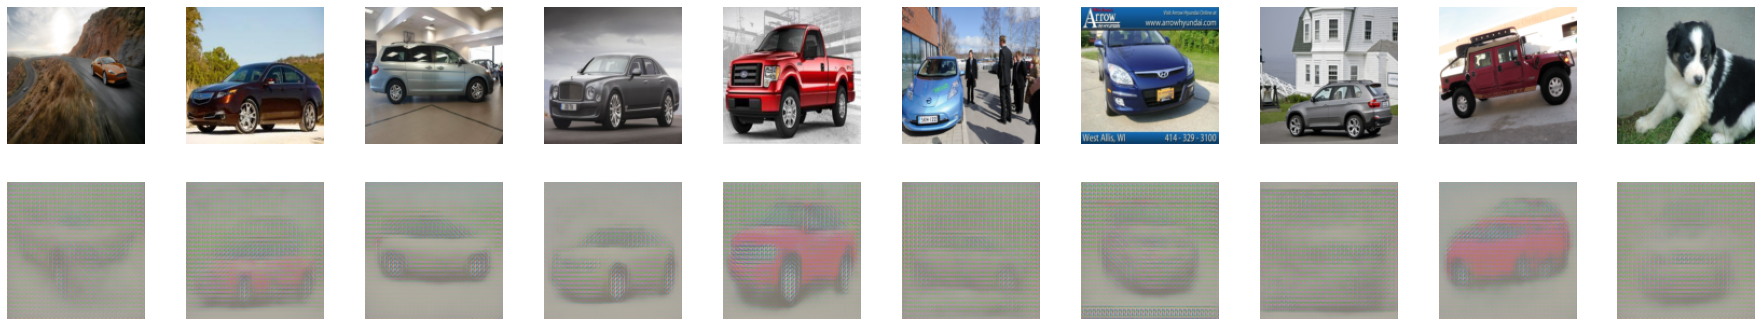

In [8]:
plt.rcParams['figure.figsize'] = [25, 5]

fig, axs = plt.subplots(2, 10)
fig.tight_layout()
axs = axs.ravel()

for i in range(20):
    if i < 10:
        image = train_data[i][0].transpose_(0,2)
        image = denormalize(image, MEAN, STD, device).numpy().astype(float)
        axs[i].imshow(image)
        axs[i].axis('off')
    else:
        image = generated_x[i-10].transpose_(0,2)
        image = denormalize(image, MEAN, STD, device).detach().cpu().numpy()
        axs[i].imshow(image)
        axs[i].axis('off')

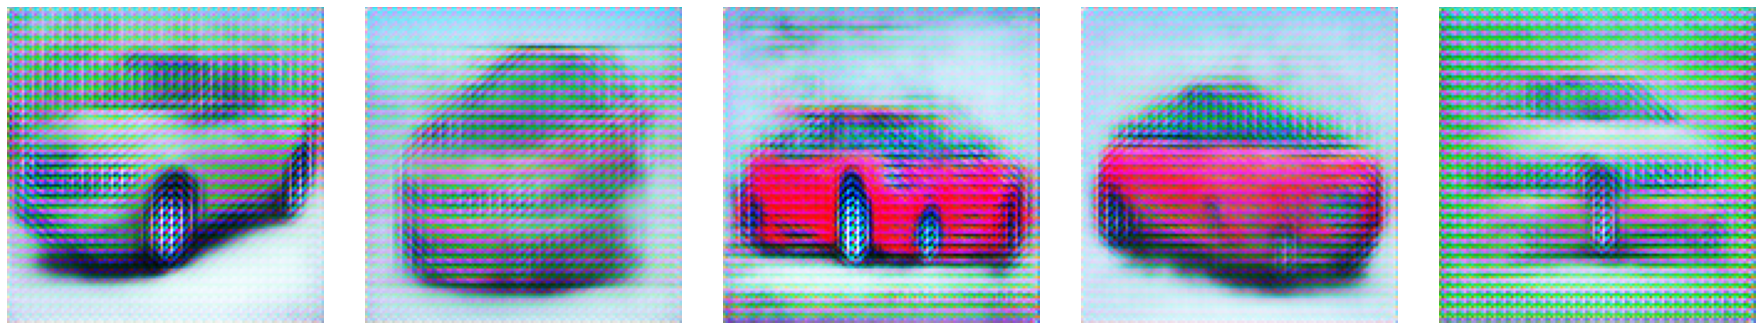

In [9]:
plt.rcParams['figure.figsize'] = [25, 5]

MU = numpy.repeat(0, LATENT_DIM)
SIGMA = numpy.diag(numpy.repeat(1, LATENT_DIM))
dt_sim = numpy.random.multivariate_normal(mean=MU, cov=SIGMA, size=32)

fig, axs = plt.subplots(1, 5)
fig.tight_layout()
axs = axs.ravel()

x = torch.from_numpy(dt_sim).float().to(device)
generated = model.decode(x)

for i in range(5):
    image = generated[i].transpose_(0,2).detach().numpy()
    axs[i].imshow(image)
    axs[i].axis('off')
plt.savefig("generated_cars.png")

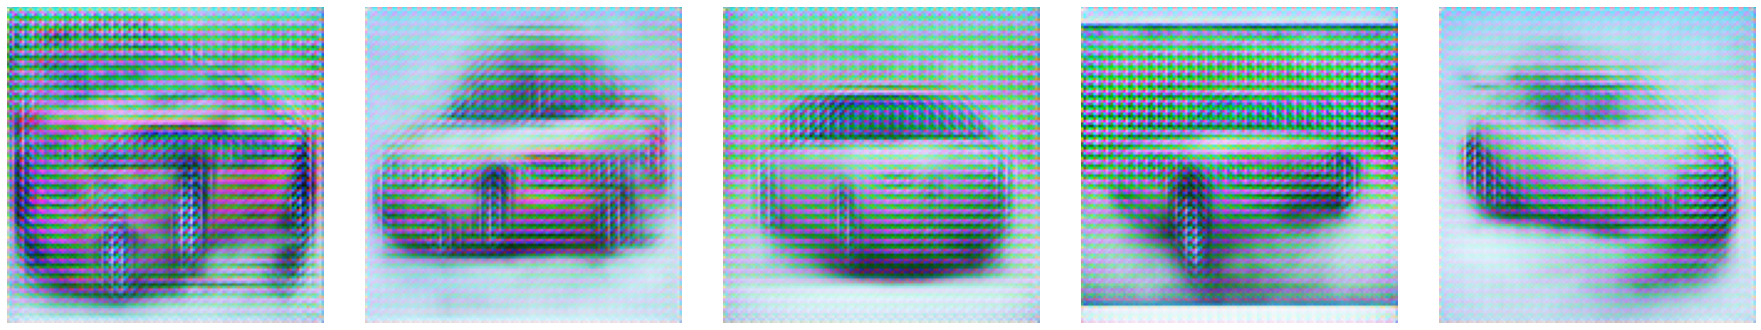

In [17]:
plt.rcParams['figure.figsize'] = [25, 5]

mu_real = numpy.mean(mu_inliers, axis=0)
sigma_real = numpy.diag(numpy.mean(sigma_inliers, axis=0))
dt_sim = numpy.random.multivariate_normal(mean=mu_real, cov=sigma_real, size=32)

fig, axs = plt.subplots(1, 5)
fig.tight_layout()
axs = axs.ravel()

x = torch.from_numpy(dt_sim).float().to(device)
generated = model.decode(x)

for i in range(5):
    image = generated[i].transpose_(0,2).detach().numpy()
    axs[i].imshow(image)
    axs[i].axis('off')

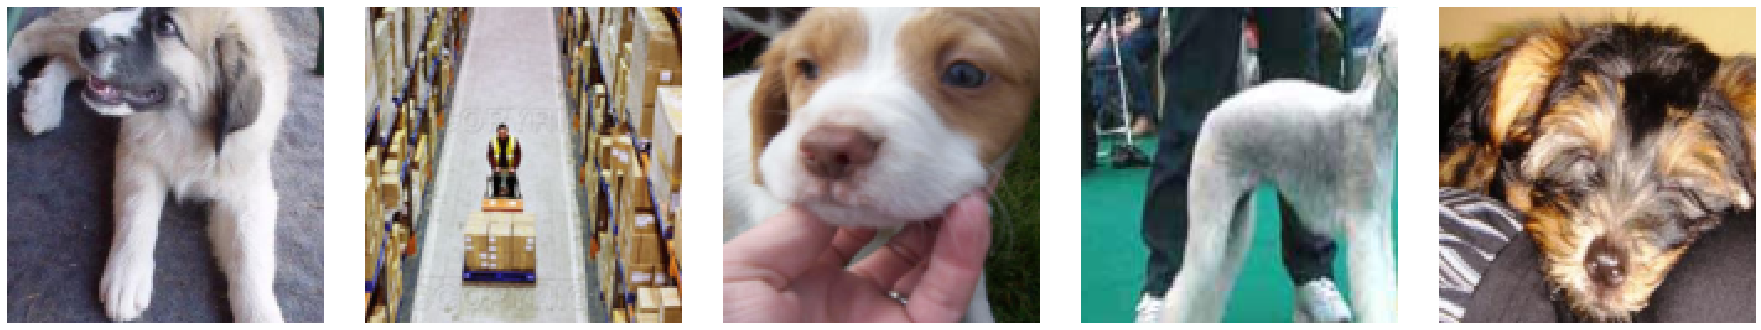

In [24]:
plt.rcParams['figure.figsize'] = [25, 5]

fig, axs = plt.subplots(1, 5)
fig.tight_layout()
axs = axs.ravel()

for i in range(5):
    image = train_data[i+5][0].transpose_(0,2)
    image = denormalize(image, MEAN, STD, device).numpy().astype(float)
    axs[i].imshow(image)
    axs[i].axis('off')

In [ ]:
# Montrer des exemples aux deux extremités 

pval, _ = compute_pval_loaders(train_loader,
                               test_loader,
                               model,
                               device=device,
                                        experiment=experiment,
                                        file=file,
                                        folder=folder)

    pval = 1 - pval  #we test on the tail
    pval_order = numpy.argsort(pval)

fig, axs = plt.subplots(5, 5)
    fig.tight_layout()
    axs = axs.ravel()

    for i in range(25):
        image = test_data[pval_order[i]][0].transpose_(0, 2)
        image = denormalize(image, MEAN, STD, device=device).numpy()
        axs[i].imshow(image)
        axs[i].axis('off')

    plt.savefig(os.path.join(FOLDER, "rejected_observations_" + file + ".png"))
    plt.show()

    fig, axs = plt.subplots(5, 5)
    fig.tight_layout()
    axs = axs.ravel()

    for i in range(25):
        image = test_data[pval_order[int(len(pval) - 1) - i]][0].transpose_(0, 2)
        image = denormalize(image, MEAN, STD, device=device).numpy()
        axs[i].imshow(image)
        axs[i].axis('off')

    experiment.log_figure(figure_name="better_observations",
                        figure=fig,
                        overwrite=True)
    plt.savefig(os.path.join(folder, "better_observations_" + file + ".png"))
    plt.show()